## Let's build a simple Pony classifier from scratch

Below we will explore a simple strategy around build a Convolutional Neural Network from scratch using the data we have. Sadly, I don't have access to Hasbro's image assets, so will work with a fairly small dataset.

Disclaimer: We kind of expect our results to be not so great! Deep Learning learns representations from LOTS OF DATA!

However, we will look at other possible strategies to improve this baseline.

To start let's confirm we have our dataset. As mentioned earlier, I used a Python script from the Google Images Download [repository](https://github.com/hardikvasa/google-images-download) to get some samples. I store them locally in the /images/pony folder: 

Let's start building a Pony Classifier CNN. Our images are downloaded and prepared to be of size (150px, 150px)

In [8]:
import warnings
warnings.filterwarnings('ignore')

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [10]:
from keras import optimizers
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['acc'])

### Data Preprocessing

We know that data should be formatted appropriately before being fed into the network. At this point we have a bunch of image files (jpeg, png, etc.) sitting on Azure blob storage. So we need to perform a few steps before these could be used for training and testing.
1. Read a file
2. Decode its content to RGB grid of pixels
3. Convert those into floating-point multi-dimensional arrays (or tensors)
4. Rescale pixel values (between 0 and 255) to the [0,1] interval

In Keras we could use ImageDataGenerator object to perform these steps as shown below:

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'images/ponies/train'
validation_dir = 'images/ponies/validate'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical')

Found 225 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (16, 150, 150, 3)
labels batch shape: (16, 3)


In [13]:
label_map = (train_generator.class_indices)

In [14]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=7,
        validation_data=validation_generator,
        validation_steps=10) 


Epoch 1/7
20/20 [==============================] - 2s 114ms/step - loss: 0.9802 - acc: 0.4926 - val_loss: 0.7334 - val_acc: 0.8138
Epoch 2/7
20/20 [==============================] - 2s 83ms/step - loss: 0.6125 - acc: 0.6539 - val_loss: 0.3982 - val_acc: 0.8897
Epoch 3/7
20/20 [==============================] - 2s 87ms/step - loss: 0.3882 - acc: 0.8747 - val_loss: 0.3571 - val_acc: 0.8828
Epoch 4/7
20/20 [==============================] - 1s 75ms/step - loss: 0.3300 - acc: 0.8778 - val_loss: 0.3370 - val_acc: 0.8759
Epoch 5/7
20/20 [==============================] - 2s 84ms/step - loss: 0.2653 - acc: 0.8901 - val_loss: 0.2176 - val_acc: 0.9379
Epoch 6/7
20/20 [==============================] - 2s 86ms/step - loss: 0.2242 - acc: 0.9217 - val_loss: 0.2235 - val_acc: 0.9103
Epoch 7/7
20/20 [==============================] - 2s 76ms/step - loss: 0.1957 - acc: 0.9248 - val_loss: 0.2096 - val_acc: 0.9172


In [15]:
model.save('my_little_pony_scratch.h5')

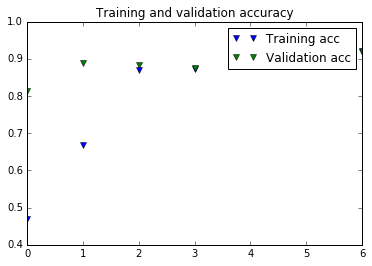

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bv', label='Training acc')
plt.plot(epochs, val_acc, 'gv', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

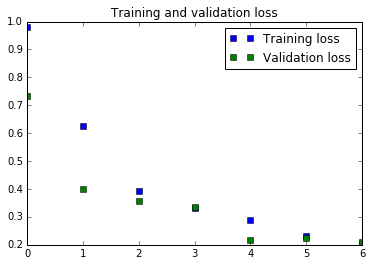

In [22]:
plt.plot(epochs, loss, 'bs', label='Training loss')
plt.plot(epochs, val_loss, 'gs', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
display()
plt.clf()

### Use our Pony CNN to score test images

In [24]:
from keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np
from keras.models import load_model

def predict_image(image_url):
  img = image.load_img(img_path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x /= 255

  model = load_model('my_little_pony_scratch.h5')

  # retrieve the most likely result, e.g. highest probability

  y_prob = model.predict(x) 
  y_classes = y_prob.argmax(axis=-1)

  class_name = [k for k, v in label_map.items() if v == y_classes[0]]
  # print the classification
  print('Prediction: class: %s, score: (%.5f)' % (class_name[0], y_prob[0][0]))

In [25]:
import os
#print(label_map)
img_folder = "images/ponies/test/"
print('----------------CUSTOM MODEL -------------------')
for filename in os.listdir(img_folder):
      img_path = os.path.join(img_folder,filename)
      print ('processing image:', img_path)
      predict_image(img_path)
      print('-----------------------------------------------------')

----------------CUSTOM MODEL -------------------
processing image: images/ponies/test/Applejack1.png
Prediction: class: Applejack, score: (0.99425)
-----------------------------------------------------
processing image: images/ponies/test/Applejack2.png
Prediction: class: Applejack, score: (0.99881)
-----------------------------------------------------
processing image: images/ponies/test/Applejack3.png
Prediction: class: Applejack, score: (0.99941)
-----------------------------------------------------
processing image: images/ponies/test/RainbowDash-1.png
Prediction: class: Rainbow_Dash, score: (0.00088)
-----------------------------------------------------
processing image: images/ponies/test/RainbowDash2.png
Prediction: class: Rainbow_Dash, score: (0.00841)
-----------------------------------------------------
processing image: images/ponies/test/Twilight-Sparkle-1.png
Prediction: class: Twilight_Sparkle, score: (0.00020)
-----------------------------------------------------
process

The End!